<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/final_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import os


drive.mount('/content/drive')

hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'


chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_chroma/ml_processed_data'
harmonic_data_folder ='/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_harmonic/ml_processed_data'
mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
onset_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_onset/ml_processed_data'
percussive_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_percussive/ml_processed_data'
spectral_centroid_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_centroid/ml_processed_data'
spectral_contrast_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_spectral_contrast/ml_processed_data'
tempo_beats_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/dataset_processed/processed_tempo_beats/ml_processed_data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            df = df.replace(r'[\[\]]', '', regex=True).astype(float) #Tempo beats data has brackets
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Find the max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load data from all specified folders
mfcc_data = load_data(mfcc_data_folder)
hist_data = load_data(hist_data_folder)
chroma_data = load_data(chroma_data_folder)
harmonic_data = load_data(harmonic_data_folder)
onset_data = load_data(onset_data_folder)
percussive_data = load_data(percussive_data_folder)
spectral_centroid_data = load_data(spectral_centroid_data_folder)
spectral_contrast_data = load_data(spectral_contrast_data_folder)
tempo_beats_data = load_data(tempo_beats_data_folder)

# Combine all features into X for the ablation study
all_features = {
    "mfcc": mfcc_data,
    "chroma": chroma_data,
    #"harmonic": harmonic_data,
    #"onset": onset_data,
    #"percussive": percussive_data,
    "spectral_centroid": spectral_centroid_data,
    #"spectral_contrast": spectral_contrast_data,
    #"tempo_beats": tempo_beats_data,
}

# Concatenate all features into a single array
X = np.concatenate(list(all_features.values()), axis=2)  # Combine along feature axis
y = hist_data

print(f"X shape: {X.shape}")  # Combined features
print(f"y shape: {y.shape}")  # Target histogram





X shape: (20, 550, 29)
y shape: (20, 550, 1)


Ablation code for investigating which features are lower in MSA

In [ ]:
import numpy as np
from itertools import combinations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import LeaveOneOut
from statistics import mean

def ablation_study_mfcc_combos(features_dict, y, epochs=10, start_combo='spectral_centroid, harmonic, percussive'):
    results = {}


    relevant_features = ['spectral_centroid'] + [feat for feat in features_dict if feat != 'spectral_centroid']
    start_recording = False  # Flag to start recording results

    for r in range(1, len(relevant_features) + 1):
        for combo in combinations(relevant_features, r):
            if 'spectral_centroid' not in combo:
                continue

            combo_name = ', '.join(combo)


            if combo_name == start_combo:
                start_recording = True

            if not start_recording:
                continue

            print(f"Evaluating combination: {combo_name}")
            losses = []

            # Combine the features for the current combination
            X_combined = np.concatenate([features_dict[feat] for feat in combo], axis=2)

            loo = LeaveOneOut()

            # Perform Leave-One-Out Cross-Validation
            for train_index, test_index in loo.split(X_combined):
                X_train, X_test = X_combined[train_index], X_combined[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Define the model
                model = Sequential([
                    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                    MaxPooling1D(pool_size=2),
                    Dropout(0.3),
                    Conv1D(128, kernel_size=3, activation='relu'),
                    MaxPooling1D(pool_size=2),
                    Dropout(0.3),
                    Flatten(),
                    Dense(X_train.shape[1], activation='linear')
                ])
                model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

                # Train the model
                model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

                # Evaluate the model
                loss = model.evaluate(X_test, y_test, verbose=0)
                losses.append(loss)

            # Average loss over LOO folds
            avg_loss = mean(losses)
            results[combo_name] = avg_loss
            print(f"Combination: {combo_name} - Avg Test MSE: {avg_loss:.4f}")

    return results


features_dict = {
    'mfcc': mfcc_data,
    'chroma': chroma_data,
    'harmonic': harmonic_data,
    'onset': onset_data,
    'percussive': percussive_data,
    'spectral_centroid': spectral_centroid_data,
    'spectral_contrast': spectral_contrast_data,
    'tempo_beats': tempo_beats_data
}


results = ablation_study_mfcc_combos(features_dict, y, epochs=10, start_combo='spectral_centroid, harmonic, percussive')

# Print the final results
print("\n--- Final Results ---")
for combo, avg_loss in results.items():
    print(f"{combo}: Avg Test MSE = {avg_loss:.4f}")


Evaluating combination: spectral_centroid, harmonic, percussive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Combination: spectral_centroid, harmonic, percussive - Avg Test MSE: 1299493.5531
Evaluating combination: spectral_centroid, harmonic, spectral_contrast
Combination: spectral_centroid, harmonic, spectral_contrast - Avg Test MSE: 1279103.0469
Evaluating combination: spectral_centroid, harmonic, tempo_beats
Combination: spectral_centroid, harmonic, tempo_beats - Avg Test MSE: 1280556.8391
Evaluating combination: spectral_centroid, onset, percussive
Combination: spectral_centroid, onset, percussive - Avg Test MSE: 1277219.0375
Evaluating combination: spectral_centroid, onset, spectral_contrast


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 1: Leaving out song at index 0
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7688247.5000
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - loss: 3314628.7500
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 2399396.2500
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 1806796.0000
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 1652409.2500
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 1621120.5000
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 1615439.0000
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1561883.2500
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 1432619.2500
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 1223444.5000
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step - loss: 1004632.1875
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - loss: 830711.8750
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 799230.3125
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 60

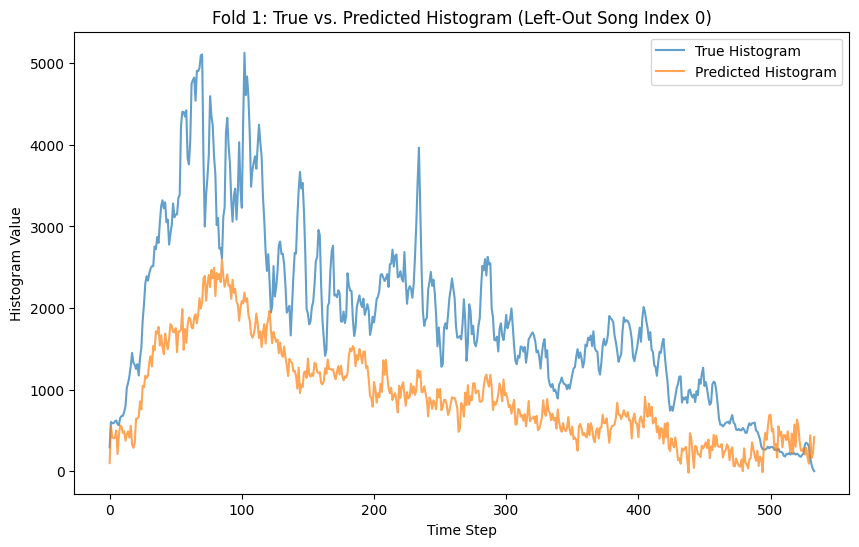

Fold 2: Leaving out song at index 1
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 330736.3438
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 305942.7812
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 289396.0625
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 298786.3125
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 283100.0625
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 275262.2500
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 233640.4531
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 217579.3438
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 208410.5000
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 201448.0000
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 179773.3281
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 166823.9062
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 158210.4062
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step

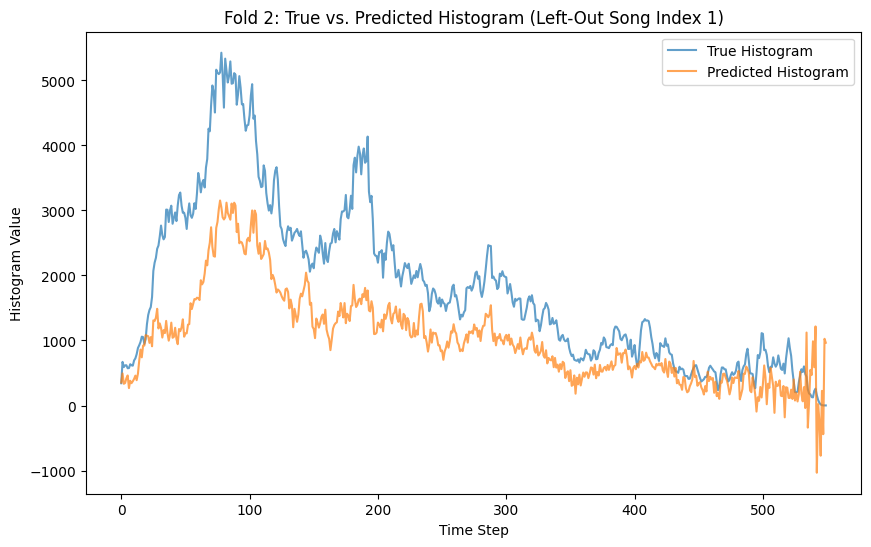

Fold 3: Leaving out song at index 2
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 93868.9453
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 85405.7188
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 81905.3359
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 86383.0469
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 85217.2656
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 79117.1016
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 81295.4531
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 75947.8281
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 67875.8203
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 68713.5625
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 69613.9531
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 73251.8438
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 78448.5234
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 6604

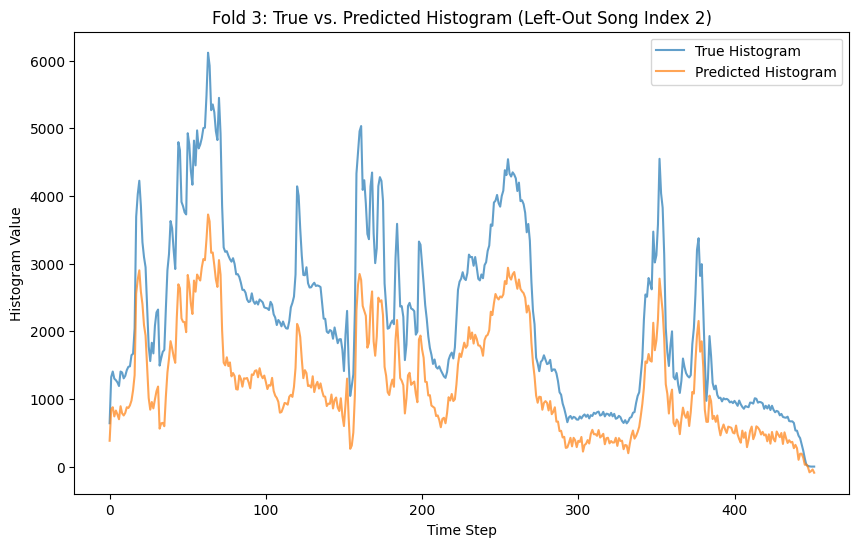

Fold 4: Leaving out song at index 3
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 61819.4062
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 54792.1094
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 52618.4844
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 53118.7422
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - loss: 64618.6719
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - loss: 50227.2812
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 55381.1133
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 56074.1719
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 50481.3086
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 50463.1523
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 50537.7695
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 51473.6523
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - loss: 51853.3164
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - loss: 51481.2305
Epoch 15/30

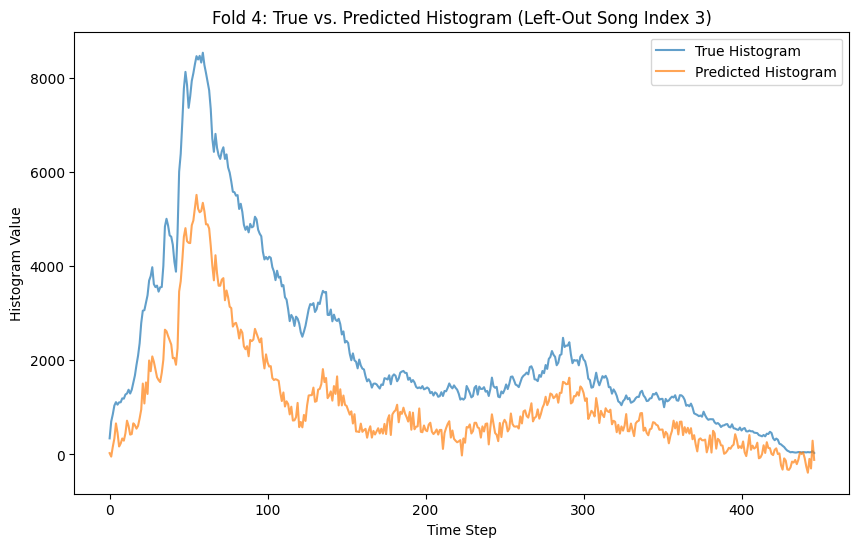

Fold 5: Leaving out song at index 4
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 53270.0508
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 46240.1758
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 51391.4922
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 44590.3711
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 53140.6406
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 49444.4141
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 47928.5898
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 44407.5352
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 51900.6289
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 45468.3047
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 47543.2773
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 49497.1172
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 44290.4414
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 4586

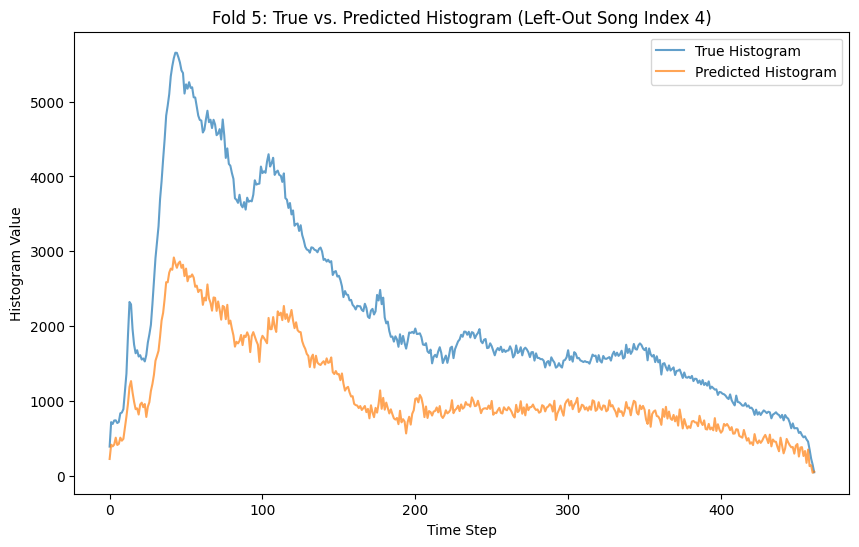

Fold 6: Leaving out song at index 5
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 47055.4961
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 48862.7656
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 43417.2969
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - loss: 40607.1094
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 43374.4766
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 47296.6875
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step - loss: 42948.2266
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 44838.8320
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 44403.0625
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 43129.8281
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 45739.3125
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 42612.8359
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 40314.4805
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 4288

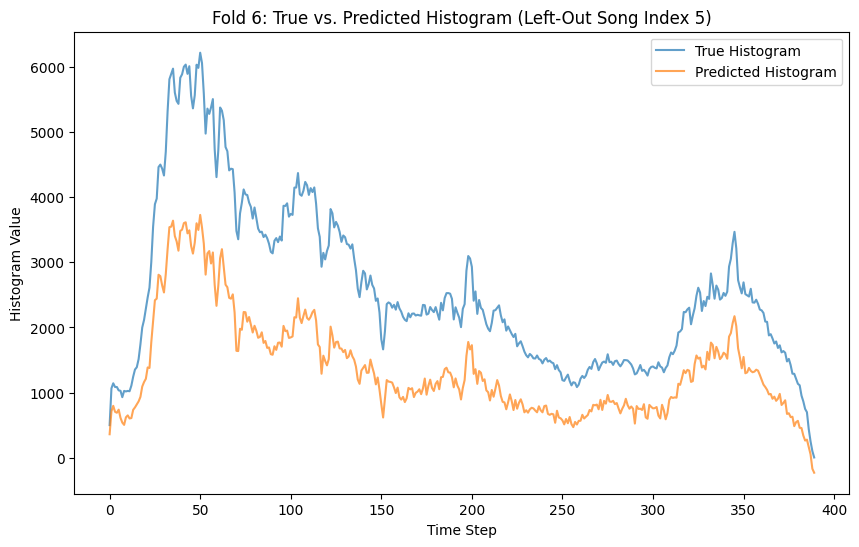

Fold 7: Leaving out song at index 6
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 38687.7305
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 38913.4727
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 40669.1133
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 36355.9688
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 37713.3359
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 42652.0938
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 38224.1328
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 41782.0430
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 35576.1953
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 34422.4219
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 37189.0664
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 38183.2500
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - loss: 35124.2461
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: 4531

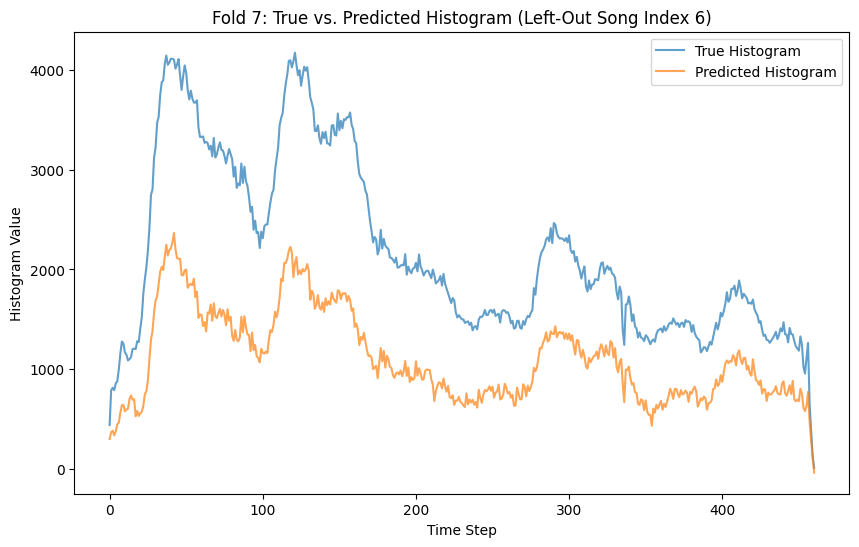

Fold 8: Leaving out song at index 7
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 37063.3594
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 33305.4375
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 35883.7539
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 39737.8633
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 32952.7383
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 35568.0000
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 36348.8555
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 30937.8691
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 35046.4727
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 35545.0938
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 34606.4375
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 33258.5781
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 36430.7227
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 3554

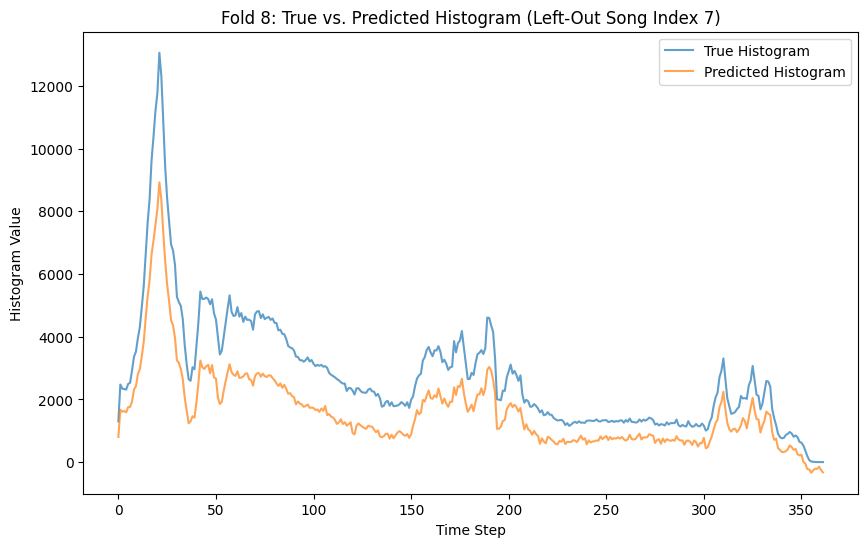

Fold 9: Leaving out song at index 8
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 33704.9883
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - loss: 29324.3984
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step - loss: 33257.7383
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - loss: 32840.5391
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 32095.0332
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 29915.1836
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 33153.2617
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 36839.6484
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 35681.7656
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 31670.9863
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 30969.9219
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 35011.6406
Test MSE for this fold: 1029018.875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test RMSE for this fold: 1014.4057006835938


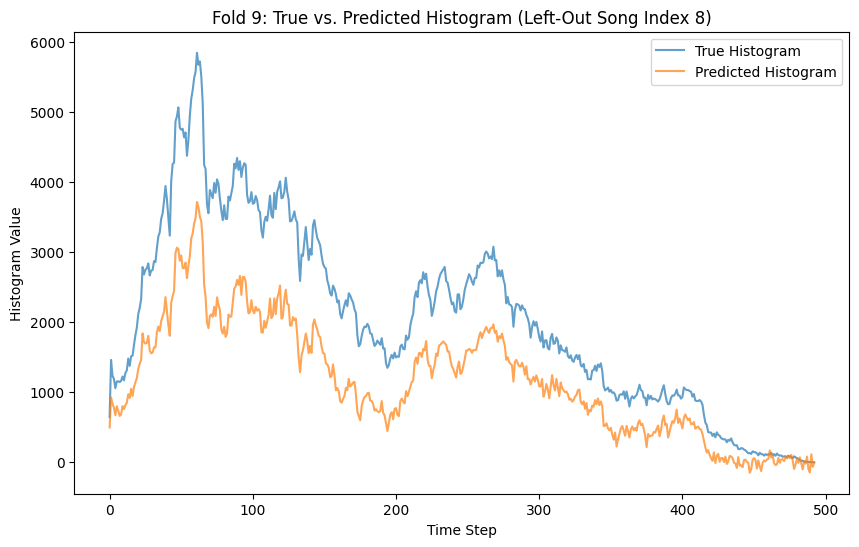

Fold 10: Leaving out song at index 9
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 30026.3906
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 31877.7266
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 34258.6914
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 28428.6719
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 33964.1445
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 29356.7891
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 29369.3457
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 28596.8359
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 30491.5254
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 29309.7656
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 30795.8066
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 33957.9141
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 32076.6016
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 305

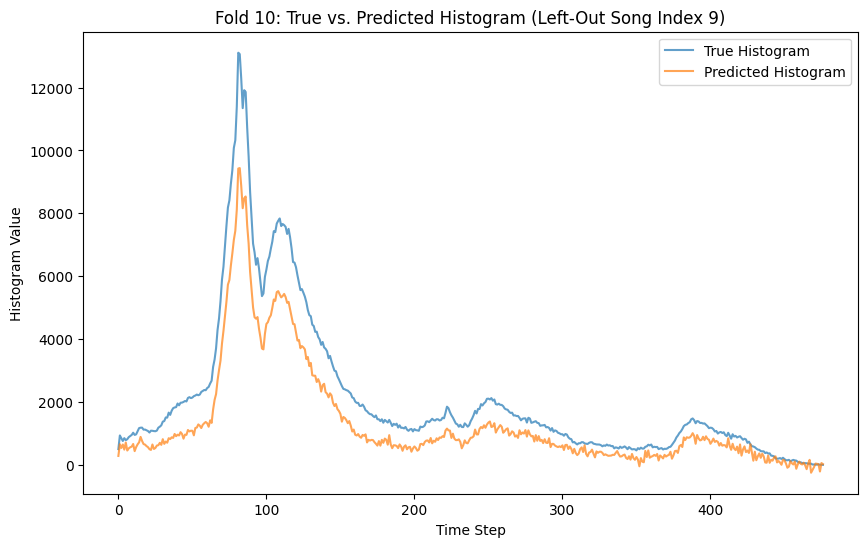

Fold 11: Leaving out song at index 10
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 30210.6641
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 35658.9922
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 29035.8906
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 35343.4609
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 33573.7383
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 34770.1289
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 29578.3906
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 35026.6211
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 32122.6719
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 32000.0684
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 30776.0879
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 34164.7031
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 29551.9844
Test MSE for this fold: 1239259.125
1/1 ━━━━━━━━━━━━━━━━━━━━ 

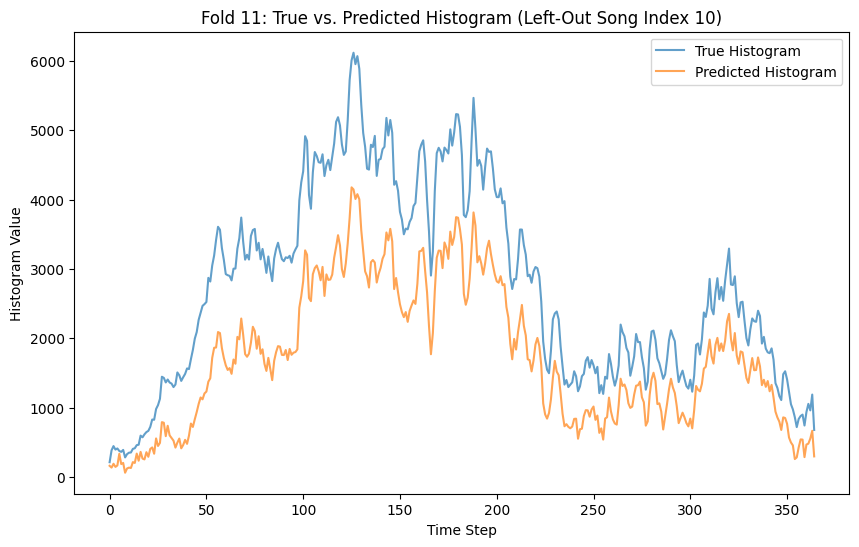

Fold 12: Leaving out song at index 11
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 28397.3848
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 37224.6367
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - loss: 32387.7559
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 27319.1973
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - loss: 26706.4961
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - loss: 32673.4805
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - loss: 26945.9180
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 29825.0098
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 30283.3711
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 27757.9121
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 28859.1777
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 29105.2891
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 25768.5820
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 31

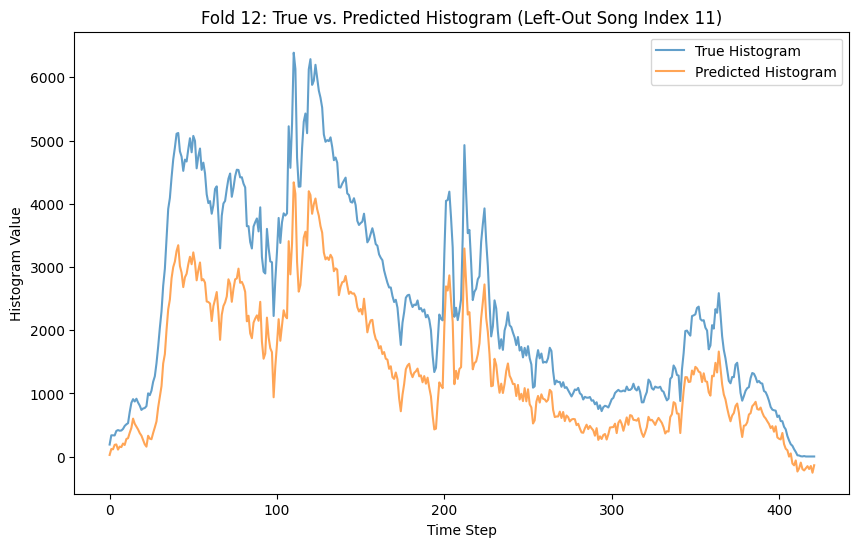

Fold 13: Leaving out song at index 12
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 28911.8516
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 28092.2031
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 26655.8086
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 30010.5586
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 27308.9102
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 28275.1113
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 30127.5762
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 28421.6445
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 27540.5234
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 26584.7207
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 28985.4844
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 27952.9570
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 30558.8809
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 29

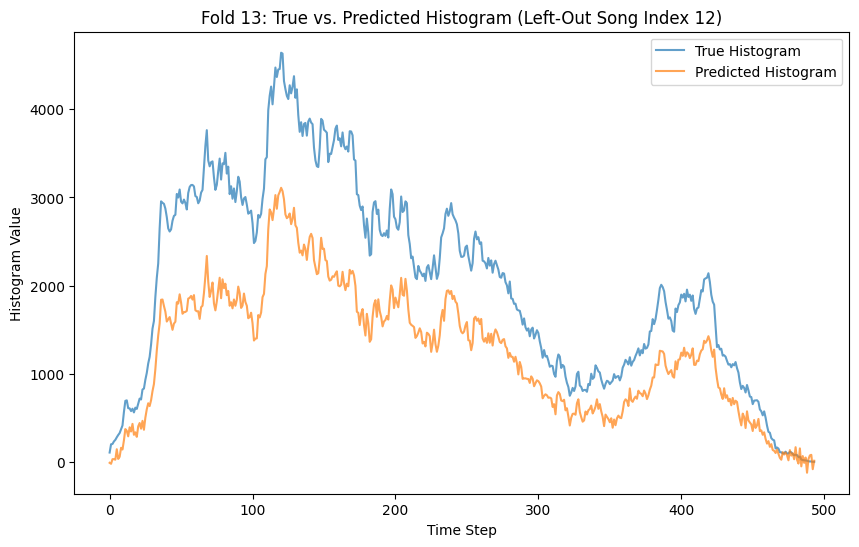

Fold 14: Leaving out song at index 13
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 26697.3457
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 24554.0996
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 24281.0273
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 26138.7227
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 24315.7363
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 24845.0977
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 25971.6016
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 24029.7422
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 29102.9277
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 25217.5078
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 24492.3418
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 27857.1914
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 29057.4863
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 24

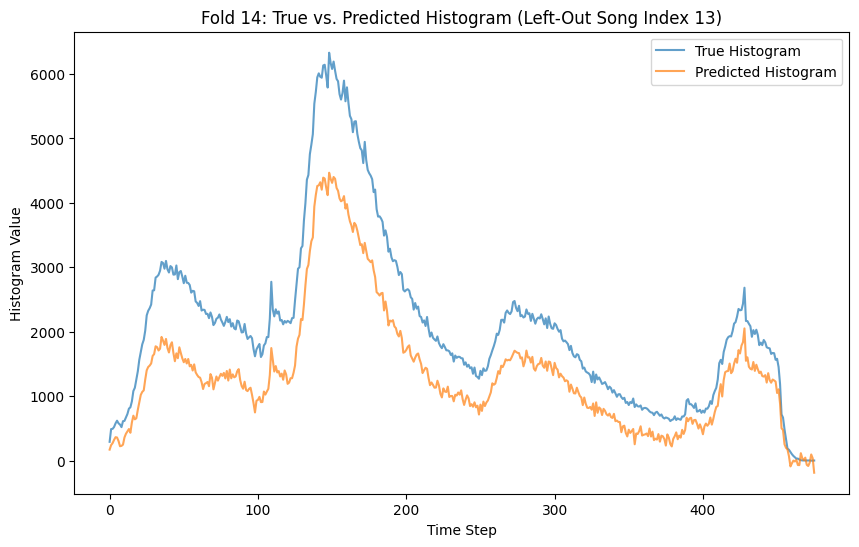

Fold 15: Leaving out song at index 14
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 22802.8984
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 21944.3340
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - loss: 28175.7344
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - loss: 26730.3848
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - loss: 24796.3301
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step - loss: 22233.4590
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 25675.3633
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 21992.8086
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 27793.5586
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - loss: 23725.5176
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 21802.9746
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 21844.3652
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 26226.5352
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 23

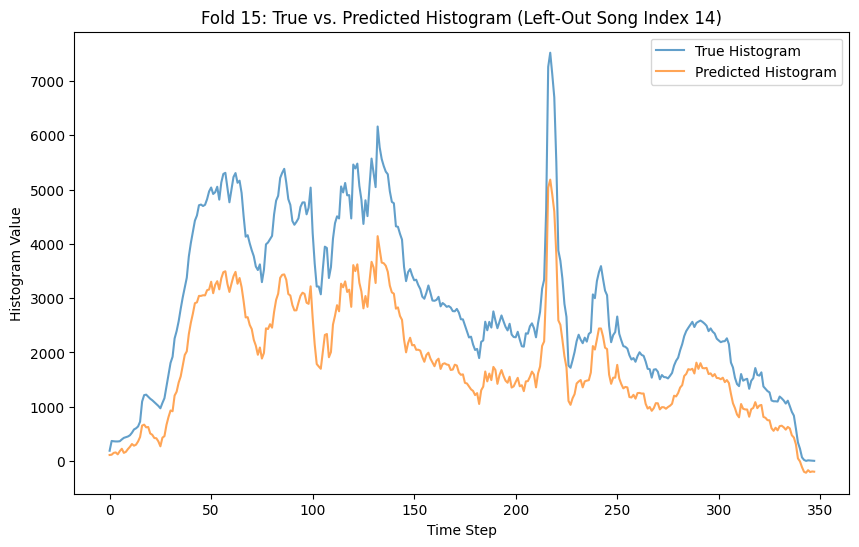

Fold 16: Leaving out song at index 15
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 23974.9395
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 24483.5078
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 20307.5820
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 20725.2129
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 26244.0430
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 22587.5078
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 22496.4316
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 22106.2812
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 20428.5977
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 22809.1973
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 29406.9082
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 25324.4219
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 20267.9531
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 21

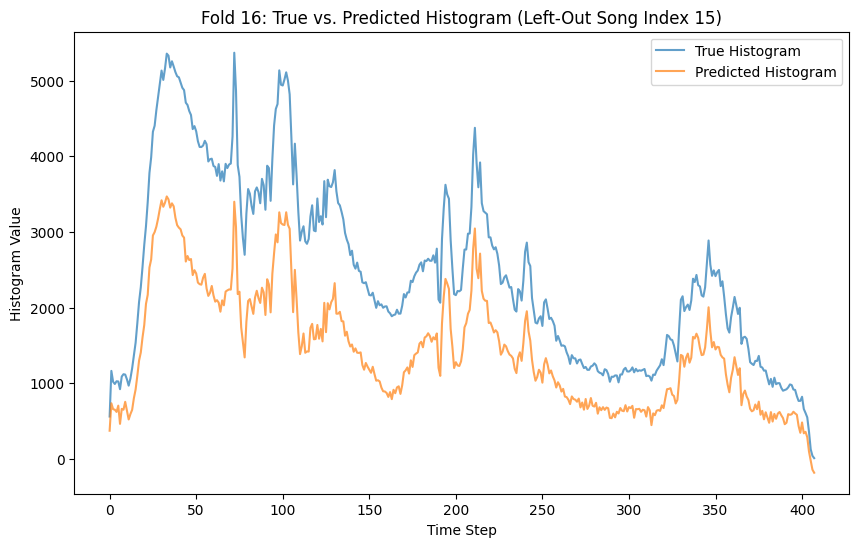

Fold 17: Leaving out song at index 16
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 22409.5801
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 24162.0254
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 20712.1621
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 22364.0645
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 22833.8965
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 20582.9141
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 23186.0215
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 21474.5020
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 18840.3828
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 21798.2441
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 21567.7070
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 19623.9668
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 20001.8594
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 22

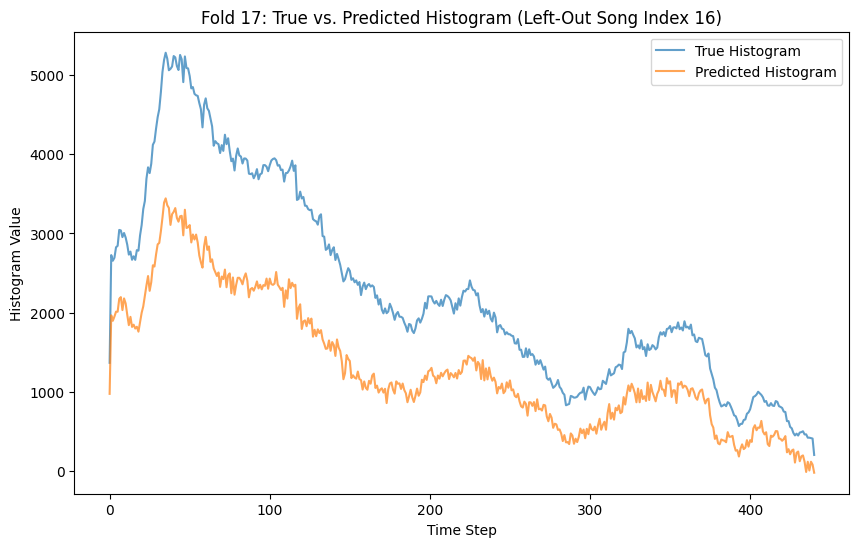

Fold 18: Leaving out song at index 17
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 21053.0273
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 19047.5508
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 20004.4922
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 18938.4023
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 19280.1426
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 22619.7969
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 21019.6953
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 19800.3457
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 21263.7090
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - loss: 22500.7266
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 19577.3730
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - loss: 20031.0781
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - loss: 17896.3262
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 19

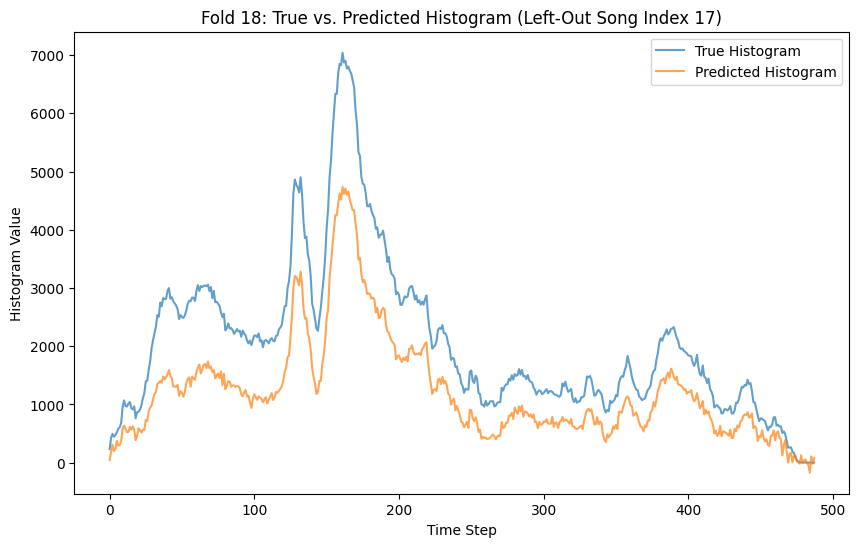

Fold 19: Leaving out song at index 18
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 19999.3750
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 25322.5117
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 19696.7441
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 23645.7656
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 29423.1309
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 17417.1445
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 22249.5195
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 19944.3379
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 18872.2695
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 18534.7578
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 17084.3516
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 21172.0137
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 21250.9473
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 20

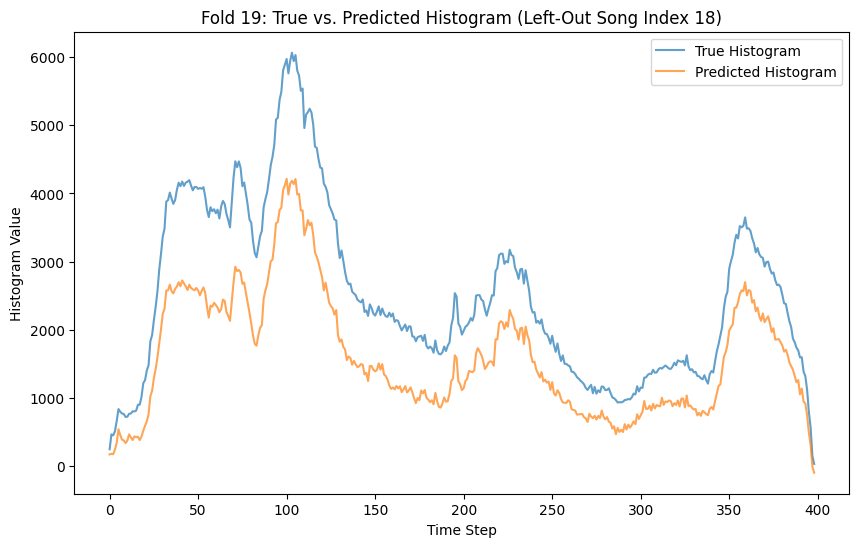

Fold 20: Leaving out song at index 19
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 23921.0938
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 17749.9004
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 17988.2090
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - loss: 17795.4648
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 17270.5039
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 19820.2578
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 22863.3223
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 18247.6016
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 20933.1230
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 21898.2285
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 16286.2002
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 17684.5977
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 18150.4199
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 23

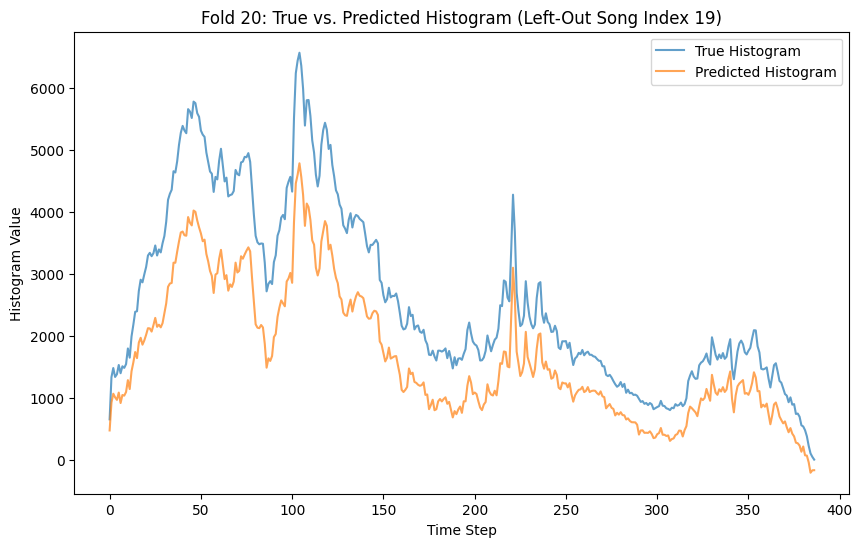

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Dynamically determine input shape from X
time_steps = X.shape[1]
features = X.shape[2]

# Custom masked loss function
def masked_mse(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())  # Mask for non-zero values
    mse = K.square(y_pred - y_true) * mask             # Compute MSE only on non-zero values
    return K.sum(mse) / K.sum(mask)                    # Normalize by the number of non-zero values


model = Sequential()
model.add(Masking(mask_value=0., input_shape=(time_steps, features)))  # Mask zero-padded values
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(time_steps, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.001), loss=masked_mse)


for fold_number, (train_index, test_index) in enumerate(loo.split(X), start=1):

    print(f"Fold {fold_number}: Leaving out song at index {test_index[0]}")
    # Split the data into training and testing sets    X_train, X_test = X[train_index], X[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=10)
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE (mask padded values)
    valid_indices = y_test.flatten() != 0  # Exclude padded values
    rmse = np.sqrt(mean_squared_error(y_test.flatten()[valid_indices], y_pred[valid_indices]))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten()[valid_indices], label='True Histogram', alpha=0.7)
    plt.plot(y_pred[valid_indices], label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title(f'Fold {fold_number}: True vs. Predicted Histogram (Left-Out Song Index {test_index[0]})')
    plt.legend()
    plt.show()
